# Diffusion Probabilistic Models - Implementación

Implementación de un modelo de difusión probabilístico según se describe en "_Deep Unsupervised Learning using Nonequilibrium Thermodynamics_".

- [https://github.com/jcmellado/sapiens/blob/main/notebooks/diffusion-models/diffusion-models.ipynb](https://github.com/jcmellado/sapiens/blob/main/notebooks/diffusion-models/diffusion-models.ipynb)

El modelo se implementa siguiendo los ejemplos de "juguete" sugeridos en el _paper_ original en _PyTorch_, lo que hoy en día no es práctico ni necesario, pero sirve para afianzar conceptos.

## 1. Setup

Para ejecutar este _notebook_ en local se requiere Python, y se recomienda crear un entorno virtual para instalar las dependencias de manera controlada.

```
uv venv --python=python3.12
source .venv/bin/activate

uv pip install torch==2.7.1
uv pip install matplotlib==3.10.3

uv pip install jupyterlab ipywidgets
uv run jupyter lab
```

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(57)

if torch.cuda.is_available():
  torch.cuda.manual_seed(57)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## 2. Data Distribution

Como _dataset_ se utiliza la distribución "_Swiss Roll_" a modo de distribución de datos 2D compleja e intratable.

In [2]:
def generate_swiss_roll(num_samples=100000, noise_std=0.5):
  t = torch.rand(num_samples, dtype=torch.float32, device=device) * 4.0 * torch.pi
  x = t * torch.cos(t)
  y = t * torch.sin(t)

  data = torch.stack([x, y], dim=1)
  data += torch.randn_like(data) * noise_std
  data = data / data.std(0, keepdim=True)

  return data

x = generate_swiss_roll()

La distribución tiene ese nombre porque su forma se asemeja a un típico dulce de bizcocho relleno enrollado sobre mismo.

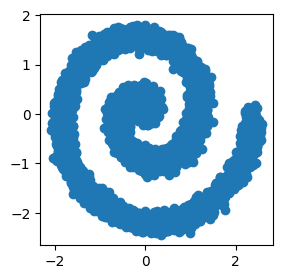

In [3]:
import matplotlib.pyplot as plt

def plot_swiss_roll(x: torch.Tensor) -> None:
  plt.figure(figsize=(3, 3))
  plt.scatter(x.cpu()[:, 0], x.cpu()[:, 1])
  plt.show()

plot_swiss_roll(x[:10000])

## 3. Scheduler

Se utiliza un _linear scheduler_ para generar las tasas de difusión $\beta_t$.

- $ \beta_t = \beta_1 + \dfrac{t - 1}{T - 1} (\beta_T - \beta_1) $

Y al tiempo que se calculan los valores $\beta_t$ se calculan los valores $\alpha_t$ y $\bar\alpha_t$.

- $ \alpha_t = 1 - \beta_t $

- $ \bar\alpha_t = \prod\limits_{i=1}^{t} \alpha_i $

Si $\beta_t$ es la cantidad de ruido que se añade en cada paso, $\alpha_t$ representa la cantidad de la señal original que se conserva.

In [4]:
def generate_betas(num_time_steps: int, beta_start: float = 0.0001, beta_end: float = 0.02) -> tuple[torch.Tensor, torch.Tensor]:
  betas = torch.linspace(beta_start, beta_end, num_time_steps, dtype=torch.float32, device=device)
  alphas = 1.0 - betas
  bar_alphas = torch.cumprod(alphas, dim=0)

  return betas, bar_alphas

num_time_steps = 40

betas, bar_alphas = generate_betas(num_time_steps)

Con un _linear scheduler_ la secuencia de valores $\beta_t$ se incrementa linealmente a cada paso de tiempo $t$.

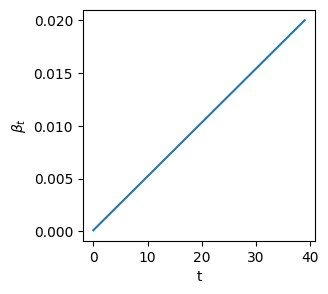

In [5]:
def plot_betas(betas: torch.Tensor) -> None:
  plt.figure(figsize=(3, 3))
  plt.xlabel('t')
  plt.ylabel('$\\beta_t$')
  plt.plot(betas.cpu())
  plt.show()

plot_betas(betas)

## 4. Diffusion Kernel

Como núcleo de difusión se utiliza el de la forma funcional gaussiana para añadir ruido.

- $ q \left( \mathbf{x}^{(t)} \mid \mathbf{x}^{(t-1)} \right) = \mathcal{N} \left( \mathbf{x}^{(t)}; \mathbf{x}^{(t-1)} \sqrt{1 - \beta_t}, \mathbf{I} \beta_t \right) $

Valores de $\beta_t$ cercanos a cero respetan la señal original, valores cercanos a uno la atenúan.

In [6]:
def diffusion_kernel(x: torch.Tensor, noise_level: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
  mean = (1.0 - betas[noise_level - 1]).sqrt()
  std = betas[noise_level - 1].sqrt()
  eps = torch.randn_like(x)

  noised = x * mean + std * eps

  return noised

Los límites del _scheduler_ determinan la cantidad mínima y máxima de ruido añadido a la señal.

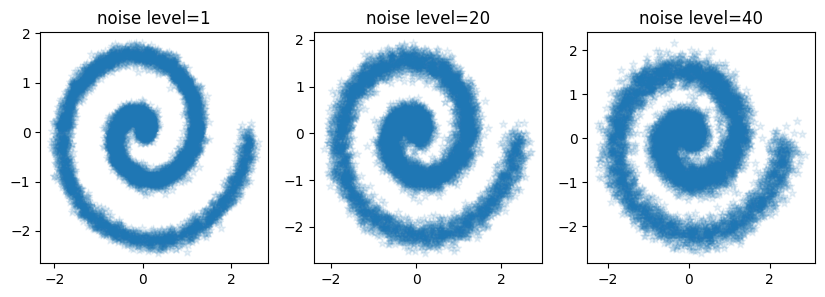

In [7]:
def plot_diffusion(x: torch.Tensor, betas: torch.Tensor) -> None:
  fig, axs = plt.subplots(1, 3, figsize=(10, 3))

  for i, value in enumerate([1, 20, 40]):
    noise_level = torch.full([len(x), 1], fill_value=value, dtype=torch.long, device=x.device)
    noised = diffusion_kernel(x, noise_level, betas).cpu()
    axs[i].scatter(noised[:, 0], noised[:, 1], marker="*", alpha=0.1)
    axs[i].set_title(f'noise level={value}')

  plt.show()

plot_diffusion(x[0:10000], betas)

## 5. The Reparameterization Trick

Para calcular $x^{(t)}$ desde $x^{(0)}$ hay que aplicar $t$ veces ruido gaussiano de manera acumulativa, lo que puede ser computacionalmente ineficiente.

Afortunadamente, el ruido gaussiano se suma de manera predecible, y puede expresarse mediante una ecuación que relaciona directamente $x^{(t)}$ con $x^{(0)}$ y un único ruido gaussiano $\epsilon$.

- $ \mathbf{x}^{(t)} = \sqrt{\bar{\alpha}_t} \mathbf{x}^{(0)} + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon} $

Este resultado permite realizar los cálculos de manera eficiente, evitando tener que aplicar el núcleo de difusión múltiples veces.

In [8]:
def noised_sample(x_0: torch.Tensor, t: torch.Tensor, bar_alphas: torch.Tensor) -> torch.Tensor:
  bar_alphas_t = bar_alphas[t.squeeze() - 1].unsqueeze(-1)  # [batch_size, 1]

  eps = torch.randn_like(x_0)

  x_t = torch.sqrt(bar_alphas_t) * x_0 + torch.sqrt(1.0 - bar_alphas_t) * eps

  return x_t

Al acumular el ruido añadido en cada paso, la distribución original se transforma progresivamente en ruido.

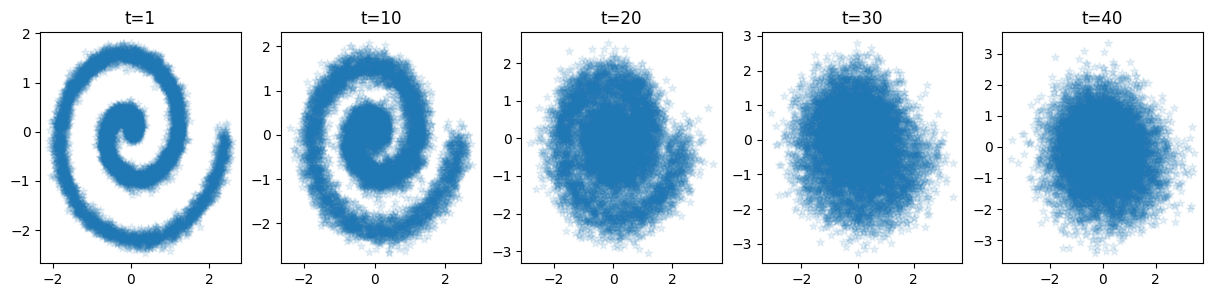

In [9]:
def plot_noised_sample(x: torch.Tensor, bar_alphas: torch.Tensor) -> None:
  fig, axs = plt.subplots(1, 5, figsize=(15, 3))

  for i, num_steps in enumerate([1, 10, 20, 30, 40]):
    t = torch.full([len(x), 1], fill_value=num_steps, dtype=torch.long, device=x.device)
    noised = noised_sample(x, t, bar_alphas).cpu()
    axs[i].scatter(noised[:, 0], noised[:, 1], marker="*", alpha=0.1)
    axs[i].set_title(f't={num_steps}')

  plt.show()

plot_noised_sample(x[:10000], bar_alphas)

## 6. Diffusion Model

El modelo de difusión debe aprender el núcleo de difusión inverso durante el entrenamiento, para poder recuperar la señal original a partir de ruido.

- $ p \left( \mathbf{x}^{(t-1)} \mid \mathbf{x}^{(t)} \right) = \mathcal{N} \left( \mathbf{x}^{(t-1)}; \mathbf{f}_{\mu} (\mathbf{x}^{(t)}, t), \mathbf{f}_{\Sigma} (\mathbf{x}^{(t)}, t) \right) $

Siendo $\mathbf{f}_{\mu}$ y $\mathbf{f}_{\Sigma}$ las funciones a aprender, y que deben retornar la media y la varianza de la distribución buscada.

El _paper_ utiliza una red de funciones de base radial (_RBF network_) para el ejemplo "_Swiss Roll_". Pero este tipo de redes no son de uso común hoy en día, por lo que se usa una red de tipo _MLP_ (_Multi-Layer Perceptron_).

- 1 capa lineal de entrada, con 3 neuronas, para las coordenadas (X, Y) del punto $x^{(t)}$ y el valor de $t$.

- 4 capas lineales ocultas, cada una con 64 neuronas, y función de activación ReLU.

- 1 capa lineal de salida para $f_{\mu}$, con 2 neuronas, para la (media X, media Y).

- 1 capa lineal de salida para $f_{\Sigma}$, con 2 neuronas, para la (varianza X, varianza Y), seguida de una función sigmoide para convertir al rango entre 0 y 1.

In [10]:
import torch.nn as nn

class DiffusionModel(nn.Module):

  def __init__(self, model_dim: int, num_time_steps: int):
    super(DiffusionModel, self).__init__()

    self.num_time_steps = num_time_steps
    
    self.layers = nn.ModuleList([
      nn.Linear(3, model_dim),
      nn.Linear(model_dim, model_dim),
      nn.ReLU(),
      nn.Linear(model_dim, model_dim),
      nn.ReLU(),
      nn.Linear(model_dim, model_dim),
      nn.ReLU(),
      nn.Linear(model_dim, model_dim),
      nn.ReLU()
    ])
    
    self.mu = nn.Linear(model_dim, 2)
    self.sigma = nn.Linear(model_dim, 2)
    self.sigmoid = nn.Sigmoid()

    self._initialize_weights()

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self, x: torch.Tensor, t: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    t_normalized = t.float().view(x.shape[0], 1) / self.num_time_steps
    x = torch.cat([x, t_normalized], dim=-1)
    
    for layer in self.layers:
      x = layer(x)
    
    f_mu = self.mu(x)
    f_sigma = self.sigmoid(self.sigma(x)) + 1e-5

    return f_mu, f_sigma

Esta arquitectura es mucho más compleja de lo que es habitual en desarrollos recientes, donde directamente se trabaja estimando el ruido $\epsilon$, no la media $\mu$ y varianza $\sigma$.

In [11]:
model = DiffusionModel(64, num_time_steps)

model.to(device)

DiffusionModel(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=64, bias=True)
    (8): ReLU()
  )
  (mu): Linear(in_features=64, out_features=2, bias=True)
  (sigma): Linear(in_features=64, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

## 7. Ground Truth

Los valores obtenidos por el modelo tienen que compararse con la distribución buscada, es decir, la distribución del paso anterior $t-1$.

Distribución gaussiana con media:

- $ \bar{\mu}_t(\mathbf{x}^{(t)}, \mathbf{x}^{(0)}) = \dfrac{\sqrt{\bar\alpha_{t-1}} \beta_t}{1 - \bar\alpha_t} \mathbf{x}^{(0)} + \dfrac{\sqrt{\alpha_t} (1 - \bar\alpha_{t-1})}{1 - \bar\alpha_t} \mathbf{x}^{(t)} $

In [12]:
def calculate_true_mean(x_0: torch.Tensor, x_t: torch.Tensor, t: torch.Tensor, betas: torch.Tensor, bar_alphas: torch.Tensor) -> torch.Tensor:
  beta_t = betas[t.squeeze() - 1].unsqueeze(-1)  # [batch_size, 1]
  bar_alpha_t = bar_alphas[t.squeeze() - 1].unsqueeze(-1)  # [batch_size, 1]
  bar_alpha_t_minus_1 = bar_alphas[t.squeeze() - 2].unsqueeze(-1)  # [batch_size, 1]

  numerator = torch.sqrt(bar_alpha_t_minus_1) * beta_t * x_0 + torch.sqrt(1.0 - beta_t) * (1.0 - bar_alpha_t_minus_1) * x_t
  denominator = torch.clamp(1.0 - bar_alpha_t, min=1e-6)
  true_mean = numerator / denominator
    
  return true_mean

Y varianza:

- $ \bar{\beta}_t = \dfrac{1 - \bar\alpha_{t-1}}{1 - \bar\alpha_t} \beta_t $

In [13]:
def calculate_true_variance(t: torch.Tensor, betas: torch.Tensor, bar_alphas: torch.Tensor) -> torch.Tensor:
  beta_t = betas[t.squeeze() - 1].unsqueeze(-1)  # [batch_size, 1]
  bar_alpha_t = bar_alphas[t.squeeze() - 1].unsqueeze(-1)  # [batch_size, 1]
  bar_alpha_t_minus_1 = bar_alphas[t.squeeze() - 2].unsqueeze(-1)  # [batch_size, 1]
  
  true_variance_scalar = ((1.0 - bar_alpha_t_minus_1) / torch.clamp((1.0 - bar_alpha_t), min=1e-6)) * beta_t
  true_variance_scalar = torch.clamp(true_variance_scalar, min=1e-6)
  true_variance = true_variance_scalar.expand(-1, 2)  # [batch_size, 2]
  
  return true_variance

## 8. Training

El entrenamiento del modelo se realiza con un bucle típico de PyTorch.

- Se toma una muestra del _dataset_ y un paso de tiempo $t$ aleatorio.

- Se aplica ruido a la muestra $t$ veces mediante el _reparameterization trick_.

- Se calcula la media y varianza de la distribución original para el paso anterior $t-1$.

- Se obtiene la media y varianza predichas por el modelo.

- Se calcula la distribución original y la predicha por el modelo.

- Se calcula la pérdida con la función de pérdida _Divergencia KL_ (_Kullback–Leibler Divergence_).

In [14]:
from torch.optim import Adam, lr_scheduler
from torch.distributions import Normal, kl_divergence

def train(model: nn.Module, x: torch.Tensor, betas: torch.Tensor, bar_alphas: torch.Tensor, num_epochs: int, batch_size: int) -> None:
  optimizer = Adam(model.parameters(), lr=0.0001)
  scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=num_epochs)

  for epoch in range(num_epochs):
    total_loss = 0
    steps = 0

    for i in range(0, len(x), batch_size):

      # Muestra y paso de tiempo t
      x_0 = x[i:i+batch_size].to(x.device)
      t = torch.randint(2, len(betas) + 1, size=[len(x_0), 1], device=x.device).long()

      # Muestra con ruido en el paso de tiempo t
      x_t = noised_sample(x_0, t, bar_alphas)

      # Media y varianza para la muestra con ruido en el paso de tiempo t
      true_mean = calculate_true_mean(x_0, x_t, t, betas, bar_alphas)
      true_variance = calculate_true_variance(t, betas, bar_alphas)

      # Media y varianza estimadas por el modelo
      f_mu, f_sigma = model(x_t, t)

      # Distribución original y estimada
      q = Normal(loc=true_mean, scale=torch.sqrt(true_variance))
      p = Normal(loc=f_mu, scale=torch.sqrt(f_sigma))

      # Pérdida
      loss = torch.mean(torch.sum(kl_divergence(q, p), dim=-1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      steps += 1
      total_loss += loss.item()

    scheduler.step()
    avg_loss = total_loss / steps
      
    if (epoch + 1) % 1000 == 1:
      current_lr = optimizer.param_groups[0]['lr']
      print(f"Época {epoch + 1}/{num_epochs}, Pérdida promedio: {avg_loss:.4f}, Learning Rate: {current_lr:.6f}")

In [15]:
model.train()

train(model, x, betas, bar_alphas, num_epochs=10000, batch_size=8192)

Época 1/10000, Pérdida promedio: 42.7694, Learning Rate: 0.000100
Época 1001/10000, Pérdida promedio: 0.2024, Learning Rate: 0.000090
Época 2001/10000, Pérdida promedio: 0.1938, Learning Rate: 0.000080
Época 3001/10000, Pérdida promedio: 0.1901, Learning Rate: 0.000070
Época 4001/10000, Pérdida promedio: 0.1880, Learning Rate: 0.000060
Época 5001/10000, Pérdida promedio: 0.1870, Learning Rate: 0.000050
Época 6001/10000, Pérdida promedio: 0.1855, Learning Rate: 0.000041
Época 7001/10000, Pérdida promedio: 0.1870, Learning Rate: 0.000031
Época 8001/10000, Pérdida promedio: 0.1883, Learning Rate: 0.000021
Época 9001/10000, Pérdida promedio: 0.1827, Learning Rate: 0.000011


## 9. Inference

Para comprobar el modelo se debe partir de una distribución de datos aleatoria y aplicar el modelo sucesivas veces verificando que se obtiene la distribución original deseada.

In [18]:
from typing import List

def denoising(num_samples: int = 10000) -> List[torch.Tensor]:
  with torch.no_grad():
    x_t = torch.randn(num_samples, 2, dtype=torch.float32, device=device)

    steps = [x_t.cpu().clone()]

    for time_step in range(num_time_steps, 1, -1):
      t = torch.tensor([time_step], dtype=torch.long, device=device).repeat(num_samples).view(-1, 1)

      f_mu, f_sigma = model(x_t, t)
      eps = torch.randn_like(x_t)
      x_t = f_mu + torch.sqrt(f_sigma) * eps

      steps.append(x_t.cpu().clone())

    x_t = x_t * torch.sqrt(1.0 - betas[0])

    steps.append(x_t.cpu().clone())

  return steps

Si el modelo está correctamente entrenado la distribución de datos en cada paso se asemejará cada vez más a la distribución original del _dataset_.

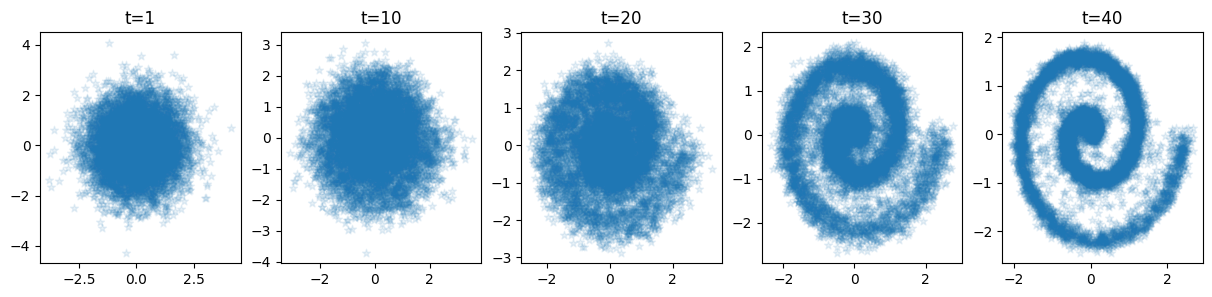

In [19]:
def plot_denoising() -> None:
  fig, axs = plt.subplots(1, 5, figsize=(15, 3))

  samples = denoising()
    
  for i, num_steps in enumerate([1, 10, 20, 30, 40]):
    sample = samples[num_steps].cpu().numpy()
    axs[i].scatter(sample[:, 0], sample[:, 1], marker="*", alpha=0.1)
    axs[i].set_title(f't={num_steps}')

  plt.show()

model.eval()

plot_denoising()